In [ ]:
# ! pip install transformers

In [ ]:
# ! pip install sentence_transformers

In [ ]:
import os
os.environ['TRANSFORMERS_CACHE'] = './huggingface'
os.environ['TORCH_HOME'] = './torch'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from torch import nn
from transformers \
  import AutoTokenizer, AutoModelForMaskedLM, BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer, util
import warnings
import re
from collections import Counter
warnings.filterwarnings("ignore")

In [ ]:
torch.cuda.is_available()

True

# Data Overview - EDA

## First Dataset

In [ ]:
sns.set_palette("pastel")

In [ ]:
design = pd.read_csv(r"D:\Work\UM\2023Fall\SI650\codes\
                     \project\data_preparation\design.csv")
digital_art = pd.read_csv(r"D:\Work\UM\2023Fall\SI650\codes\
                          \project\data_preparation\digital_art.csv")
illustration = pd.read_csv(r"D:\Work\UM\2023Fall\SI650\codes\
                           \project\data_preparation\illustration.csv")
nature = pd.read_csv(r"D:\Work\UM\2023Fall\SI650\codes\
                     \project\data_preparation\nature.csv")

In [ ]:
design['category'] = 'design'
digital_art['category'] = 'digital_art'
illustration['category'] = 'illustration'
nature['category'] = 'nature'

Sample of data.

In [ ]:
design.head()

,pic_url,title,prompt_url,prompt,tag,related_urls,related_pic_urls,related_titles,category
0,https://promptlibrary.org/wp-content/uploads/2...,Natural Logo for Ohio Valley,https://promptlibrary.org/midjourney/natural-l...,"transparent background, natural logo for softw...","['branding', 'Business', 'creativity', 'design...",['https://promptlibrary.org/midjourney/busy-gi...,['https://promptlibrary.org/wp-content/uploads...,"['Busy Girl Multiple Phones', 'Multiethnic Bus...",design
1,https://promptlibrary.org/wp-content/uploads/2...,Autumn Leaves Cartoon Pattern,https://promptlibrary.org/midjourney/autumn-le...,infinite autumn leaves pattern on a white back...,"['autumn', 'Cartoon', 'design', 'fall', 'folia...",['https://promptlibrary.org/midjourney/fantasy...,['https://promptlibrary.org/wp-content/uploads...,"['Fantasy Pink and Green', 'Navy Grey Plaid Wa...",design
2,https://promptlibrary.org/wp-content/uploads/2...,AP Versace Medusa Logo Vector,https://promptlibrary.org/midjourney/ap-versac...,the letter “AP” in the Egyptian all mean Versa...,"['accessories', 'apparel', 'branding', 'design...",['https://promptlibrary.org/midjourney/hyperde...,['https://promptlibrary.org/wp-content/uploads...,"['Hyperdetailed Gold Disco Pattern', 'Hyperdet...",design
3,https://promptlibrary.org/wp-content/uploads/2...,Undulating Forest Sculpture Design,https://promptlibrary.org/midjourney/undulatin...,forest park sculpture design by santiago calat...,"['8K', 'bronze', 'design', 'Santiago Calatrava...",['https://promptlibrary.org/midjourney/trigger...,['https://promptlibrary.org/wp-content/uploads...,"['Triggers Kawaii Fashion Epic', 'Illuminated ...",design
4,https://promptlibrary.org/wp-content/uploads/2...,Purple Tulip Watercolor Set,https://promptlibrary.org/midjourney/purple-tu...,"set of floral watercolor, purple tulip, isolat...","['botanical', 'decoration', 'design', 'floral'...",['https://promptlibrary.org/midjourney/mechani...,['https://promptlibrary.org/wp-content/uploads...,"['Mechanical Hottie A Cyberpunk Masterpiece', ...",design


Concat all the data together into one file.

In [ ]:
data_all = pd.concat([design, digital_art, illustration, nature])
data_all.shape

(7432, 9)

Distribution of categories of prompts.

Text(0, 0.5, 'Count')

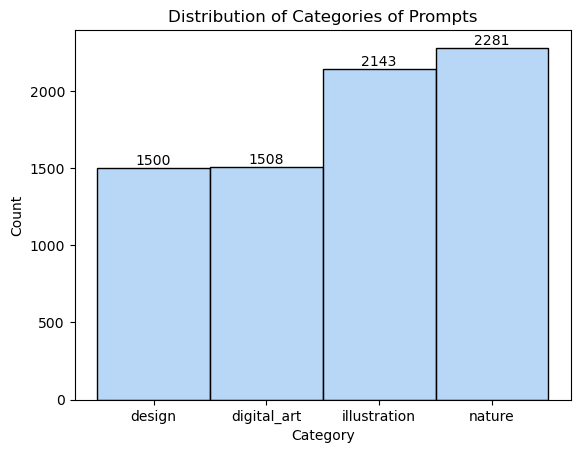

In [ ]:
ax = sns.histplot(data_all, x='category')
for i in ax.containers:
    ax.bar_label(i, )
plt.title('Distribution of Categories of Prompts')

plt.xlabel('Category')
plt.ylabel('Count')

We can see that the four categories have an almost-uniform distribution, with illustration and nature have around 2200 rows of data and design and digital art have around 1500 entries.

Check null values.

In [ ]:
data_all.isna().sum()

pic_url             0
title               0
prompt_url          0
prompt              0
tag                 0
related_urls        0
related_pic_urls    0
related_titles      0
category            0
dtype: int64

Check duplicated values.

In [ ]:
data_all[data_all.duplicated()]

,pic_url,title,prompt_url,prompt,tag,related_urls,related_pic_urls,related_titles,category


Modify data structures.

In [ ]:
data_all['tag_list'] = data_all['tag'].str.replace('\[', '') \
                  .str.replace('\]', '') \
                  .str.replace("'", '')
data_all['related_titles_list'] = data_all['related_titles'] \
                  .str.replace('\[', '') \
                  .str.replace('\]', '') \
                  .str.replace("'", '')

Find the ten most comman tags.

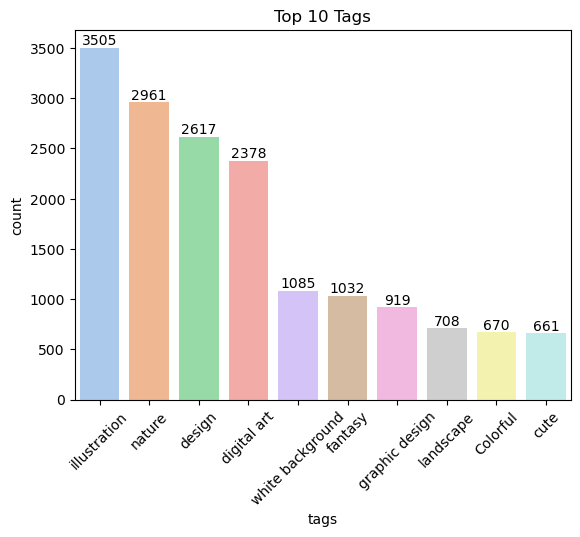

In [ ]:
tags = data_all['tag'].apply(eval)
top_10_tags = tags.explode().value_counts()[:10]
plt.xticks(rotation=45)
plt.title('Top 10 Tags')
plt.xlabel('tags')
plt.ylabel('count')
ax = sns.barplot(x=top_10_tags.index,
    y=top_10_tags.values)
for i in ax.containers:
    ax.bar_label(i, )

We observe that the majority of items fall under the "category nature," followed by "illustration," and then "digital_art" and "design." It is noteworthy that the top four tags align with the category names. However, it's essential to note that having a tag that matches the category name does not guarantee automatic categorization. The categorization process takes multiple factors into consideration, such as the context of the prompts and the presence of other tags.

Find the top 10 related titles.

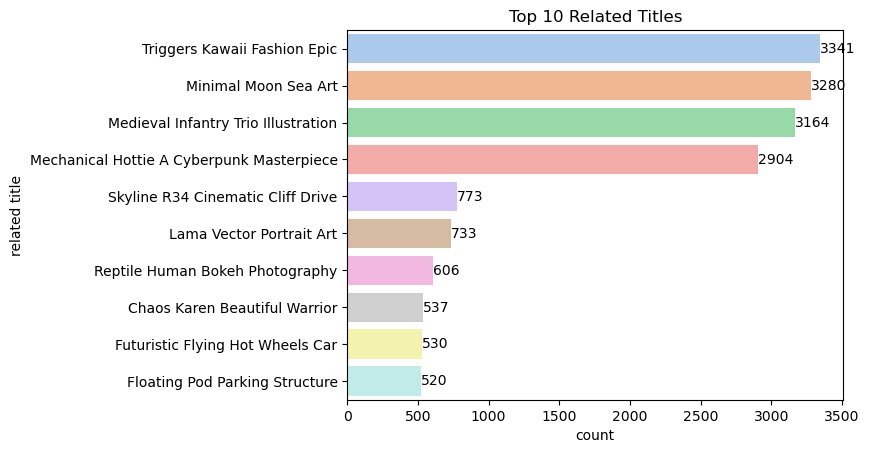

In [ ]:
titles = data_all['related_titles'].apply(eval)
top_10_titles = titles.explode().value_counts()[:10]
plt.title('Top 10 Related Titles')
plt.ylabel('related title')
plt.xlabel('count')
ax = sns.barplot(x=top_10_titles.values,
    y=top_10_titles.index,
    orient='h')
for i in ax.containers:
    ax.bar_label(i, )

It is noteworthy that the top 4 related titles have significantly more counts than others. If necessary, we can analyze the effect of these four related titles as well.

Distribution of length of prompts and titles.

Text(0.5, 1.0, 'Distribution of Prompt Length')

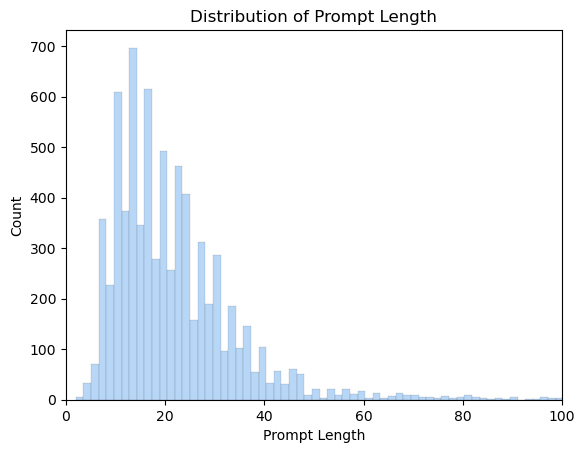

In [ ]:
length_prompt = data_all['prompt'].str.split().apply(len)
sns.histplot(length_prompt)
plt.xlim(0, 100)
plt.xlabel('Prompt Length')
plt.ylabel('Count')
plt.title('Distribution of Prompt Length')

We can see that the prompt length is right-skewed, with more prompts have length around 10 to 25. There are very few prompts with length over 60.

Text(0.5, 1.0, 'Distribution of Title Length')

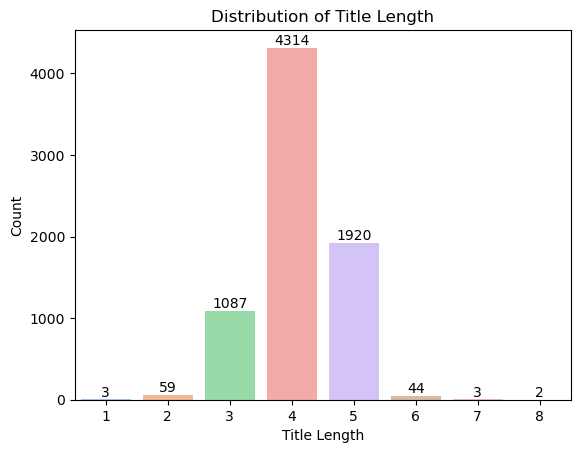

In [ ]:
length_title = data_all['title'].str.split().apply(len)
length_title_count = length_title.value_counts()
ax = sns.barplot(x=length_title_count.index, y=length_title_count.values)
for i in ax.containers:
    ax.bar_label(i, )
plt.xlabel('Title Length')
plt.ylabel('Count')
plt.title('Distribution of Title Length')

We can see that most titles have length 4 and the majority of titles have length 3-5. There are very few titles with length other than these 3 values.

## Second Dataset

In [ ]:
prompts_data = pd.read_csv('diffusion_prompts.csv.zip', index_col=0)
prompts_data.shape

(907953, 6)

In [ ]:
prompts_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907953 entries, 0 to 907952
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           907953 non-null  object
 1   prompt       907951 non-null  object
 2   url          907953 non-null  object
 3   width        907953 non-null  int64 
 4   height       907953 non-null  int64 
 5   source_site  907953 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.5+ MB


There exist some null values on the prompt column of this data set.

Deal with null and duplicated values.

In [ ]:
prompts_data = prompts_data.dropna(subset=['prompt'])
prompts_data = prompts_data.drop_duplicates()

# Feature Engineering

Add related_titles and tags information to thr original prompt.

In [ ]:
# add tag feature
data_all['prompt'] = data_all['related_titles_list'] \
            + data_all['tag_list'] \
            + data_all['prompt']
data_all['prompt'].head()

0    Busy Girl Multiple Phones, Multiethnic Busines...
1    Fantasy Pink and Green, Navy Grey Plaid Waterc...
2    Hyperdetailed Gold Disco Pattern, Hyperdetaile...
3    Triggers Kawaii Fashion Epic, Illuminated Pola...
4    Mechanical Hottie A Cyberpunk Masterpiece, Bea...
Name: prompt, dtype: object

In [ ]:
data = data_all[['prompt', 'category']]
data.head()

,prompt,category
0,"Busy Girl Multiple Phones, Multiethnic Busines...",design
1,"Fantasy Pink and Green, Navy Grey Plaid Waterc...",design
2,"Hyperdetailed Gold Disco Pattern, Hyperdetaile...",design
3,"Triggers Kawaii Fashion Epic, Illuminated Pola...",design
4,"Mechanical Hottie A Cyberpunk Masterpiece, Bea...",design


Normalize the data by lowercasing all prompts and convert tags to list.

In [ ]:
data['prompt'] = data['prompt'].str.lower()
data_all['tag'] = data_all['tag'].apply(eval)
data.head()

,prompt,category
0,"busy girl multiple phones, multiethnic busines...",design
1,"fantasy pink and green, navy grey plaid waterc...",design
2,"hyperdetailed gold disco pattern, hyperdetaile...",design
3,"triggers kawaii fashion epic, illuminated pola...",design
4,"mechanical hottie a cyberpunk masterpiece, bea...",design


Calculate the top few most frequent words in the second dataset's prompts to see if there are intersections with common tags.

In [ ]:
count = Counter()
for _, row in prompts_data.iterrows():
    words = re.findall(r'\w+', row['prompt'].lower())
    count.update(words)
top_prompt_words = set([i for i, _ in count.most_common(100)])

In [ ]:
top_100_tags = set(data_all['tag'].explode() \
        .value_counts().head(100).index.str.lower().to_list())

In [ ]:
top_tags = top_prompt_words & top_100_tags
top_tags = list(top_tags)
top_tags

['logo',
 'painting',
 'style',
 'design',
 'fantasy',
 'photorealistic',
 'portrait',
 'futuristic',
 'detailed',
 '4k',
 'digital',
 'photography',
 'white',
 'realistic',
 'background',
 'hd',
 '8k',
 'cute',
 'dark',
 '3d',
 'blue',
 'woman',
 'illustration',
 'beautiful',
 'green',
 'art',
 'anime']

Use the common tags as categorical features.

In [ ]:
tags_feature = []
for _, row in data_all.iterrows():
  feature = [0] * len(top_tags)
  for item in row['tag']:
    if item.lower() in top_tags:
      feature[top_tags.index(item.lower())] = 1
  tags_feature.append(feature)

In [ ]:
tags_feature = pd.DataFrame(tags_feature, columns=top_tags)
data = data.set_index(np.arange(len(data)))
tags_feature.head()

,logo,painting,style,design,fantasy,photorealistic,portrait,futuristic,detailed,4k,...,cute,dark,3d,blue,woman,illustration,beautiful,green,art,anime
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Preparation

## [For BERT] Sample Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sample BERT encoding.

In [ ]:
example_text = data.iloc[0]['prompt']
bert_input = tokenizer(example_text,
                       padding='max_length',
                       max_length = 512,
                       truncation=True,
                       return_tensors="pt")

print(example_text)
print(bert_input['input_ids'])

busy girl multiple phones, multiethnic business success team, chinese office meeting moderated, five coworkers in workplacebranding, business, creativity, design, digital marketing, innovation, logo, minimalism, natural, professional, simplicity, software, technology, transparent backgroundtransparent background, natural logo for software business called ohio valley digital --s 750 --v 5.1
tensor([[  101,  5697,  2611,  3674, 11640,  1010,  4800, 11031,  8713,  2449,
          3112,  2136,  1010,  2822,  2436,  3116,  8777,  2094,  1010,  2274,
         11190,  2953, 11451,  1999, 16165, 23544,  2075,  1010,  2449,  1010,
         14842,  1010,  2640,  1010,  3617,  5821,  1010,  8144,  1010,  8154,
          1010, 10124,  2964,  1010,  3019,  1010,  2658,  1010, 17839,  1010,
          4007,  1010,  2974,  1010, 13338,  4281,  6494,  3619, 19362,  4765,
          4281,  1010,  3019,  8154,  2005,  4007,  2449,  2170,  4058,  3028,
          3617,  1011,  1011,  1055,  9683,  1011,  10

In [ ]:
bert_input.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

Decode the embeddings.

In [ ]:
example_text = tokenizer.decode(bert_input.input_ids[0])
print(example_text)

[CLS] busy girl multiple phones, multiethnic business success team, chinese office meeting moderated, five coworkers in workplacebranding, business, creativity, design, digital marketing, innovation, logo, minimalism, natural, professional, simplicity, software, technology, transparent backgroundtransparent background, natural logo for software business called ohio valley digital - - s 750 - - v 5. 1 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

## [For BERT] Define the Dataset

In [ ]:
labels = {
    'design': 0,
    'digital_art': 1,
    'illustration': 2,
    'nature': 3
}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.labels = [labels[label] for label in data['category']]
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.texts = [self.tokenizer(text,
                                padding='max_length',
                                max_length = 512,
                                truncation=True,
                                return_tensors="pt")
                      for text in data['prompt']]

    def get_categories(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [ ]:
Dataset(data)

## [For Other Models] Encoding


Use sentence transformer to encode the prompts.

In [ ]:
bi_encoder_model_name = "sentence-transformers/msmarco-MiniLM-L12-cos-v5"
model = SentenceTransformer(bi_encoder_model_name, device="cuda")

In [ ]:
encoded_embeddings = []

for index, row in tqdm(data.iterrows()):
  text = row['prompt']
  embedding = model.encode(text)
  encoded_embeddings.append(embedding)

data['embeddings'] = encoded_embeddings

0it [00:00, ?it/s]

In [ ]:
np.save("data_encoded_no_punc.npy", encoded_embeddings)

In [ ]:
encoded_embeddings = np.load('data_encoded_no_punc.npy')
encoded_embeddings

array([[-7.45310187e-02,  6.31770268e-02, -1.52646722e-02, ...,
         4.02660072e-02,  1.88157956e-05,  3.09974253e-02],
       [-2.54712217e-02,  2.89598596e-03, -2.01591719e-02, ...,
        -4.42694016e-02,  3.46261300e-02, -1.14003569e-02],
       [-4.27732803e-02,  3.03156506e-02,  1.32590793e-02, ...,
        -1.02823466e-01,  5.34691103e-02,  1.13074286e-02],
       ...,
       [-1.92631502e-02,  1.18287407e-01,  3.71747417e-03, ...,
        -7.76769668e-02,  4.11408804e-02,  1.50619922e-02],
       [ 9.75773577e-03,  4.54067066e-02,  1.30069135e-02, ...,
        -1.22117503e-02, -7.66408741e-02,  2.09640767e-02],
       [-2.57226434e-02,  8.23595971e-02, -5.83322532e-03, ...,
         2.98565272e-02, -2.52636615e-02, -1.81409642e-02]], dtype=float32)

In [ ]:
data['embeddings'] = [i for i in encoded_embeddings]

In [ ]:
data.head()

,prompt,category,embeddings
0,"busy girl multiple phones, multiethnic busines...",design,"[-0.07453102, 0.06317703, -0.015264672, -0.041..."
1,"fantasy pink and green, navy grey plaid waterc...",design,"[-0.025471222, 0.002895986, -0.020159172, 0.07..."
2,"hyperdetailed gold disco pattern, hyperdetaile...",design,"[-0.04277328, 0.03031565, 0.013259079, -0.0273..."
3,"triggers kawaii fashion epic, illuminated pola...",design,"[-0.014823819, 0.033588488, 0.038925305, 0.055..."
4,"mechanical hottie a cyberpunk masterpiece, bea...",design,"[-0.0044794413, 0.03887741, -0.022477755, -0.0..."


In [ ]:
labels = {
    'design': 0,
    'digital_art': 1,
    'illustration': 2,
    'nature': 3
}

data['category_y'] = data['category'].map(labels)

In [ ]:
data.sample(5)

,prompt,category,embeddings,category_y
7079,"goya-esque landscape with lighting, skyline r3...",nature,"[-0.011604762, 0.020602785, 0.029197164, 0.102...",3
4027,"reptile human bokeh photography, tiger battle ...",illustration,"[-0.0028363867, 0.061932936, 0.018656835, -0.0...",2
254,"lama vector portrait art, scuba cat hunting fi...",design,"[-0.05205257, 0.06433177, 0.05882873, -0.00769...",0
3168,"bathhouse body cinematic masterpiece, perfect ...",illustration,"[0.055315554, 0.120995134, -0.054250542, 0.039...",2
209,"futuristic flying hot wheels car, floating pod...",design,"[-0.005771272, 0.064321846, -0.05811153, 0.042...",0


In [ ]:
data = pd.concat((data, tags_feature), axis=1)
data.head()

,prompt,category,embeddings,category_y,logo,painting,style,design,fantasy,photorealistic,...,cute,dark,3d,blue,woman,illustration,beautiful,green,art,anime
0,"busy girl multiple phones, multiethnic busines...",design,"[-0.07453102, 0.06317703, -0.015264672, -0.041...",0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"fantasy pink and green, navy grey plaid waterc...",design,"[-0.025471222, 0.002895986, -0.020159172, 0.07...",0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,"hyperdetailed gold disco pattern, hyperdetaile...",design,"[-0.04277328, 0.03031565, 0.013259079, -0.0273...",0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"triggers kawaii fashion epic, illuminated pola...",design,"[-0.014823819, 0.033588488, 0.038925305, 0.055...",0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"mechanical hottie a cyberpunk masterpiece, bea...",design,"[-0.0044794413, 0.03887741, -0.022477755, -0.0...",0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## [For Both] Dataset Split

In [ ]:
np.random.seed(42)
data_train, data_val, data_test = np.split(data.sample(frac=1, random_state=42),
                                     [int(.8*len(data)), int(.9*len(data))])

print(len(data_train),len(data_val), len(data_test))

5945 743 744


# Model Preparation

## BERT

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768, 4)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = \
        self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_1_output = self.dropout(pooled_output)
        linear_1_output = self.linear_1(dropout_1_output)
        final_layer = self.relu(linear_1_output)
        return final_layer

In [ ]:
class BertClassifier_l2(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier_l2, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768, 512)
        self.linear_2 = nn.Linear(512, 4)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = \
        self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_1_output = self.dropout(pooled_output)
        linear_1_output = self.linear_1(dropout_1_output)
        relu_1_output = self.relu(linear_1_output)
        dropout_2_output = self.dropout(relu_1_output)
        linear_2_output = self.linear_2(dropout_2_output)
        final_layer = self.relu(linear_2_output)
        return final_layer

In [ ]:
class BertClassifier_l3(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier_l3, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768, 512)
        self.linear_2 = nn.Linear(512, 256)
        self.linear_3 = nn.Linear(256, 4)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = \
        self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        # print(pooled_output)
        dropout_1_output = self.dropout(pooled_output)
        linear_1_output = self.linear_1(dropout_1_output)
        relu_1_output = self.relu(linear_1_output)
        dropout_2_output = self.dropout(relu_1_output)
        linear_2_output = self.linear_2(dropout_2_output)
        relu_2_output = self.relu(linear_2_output)
        dropout_3_output = self.dropout(relu_2_output)
        linear_3_output = self.linear_3(dropout_3_output)
        final_layer = self.relu(linear_3_output)
        return final_layer

In [ ]:
class BertClassifier_l4(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier_l4, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(768, 512)
        self.linear_2 = nn.Linear(512, 256)
        self.linear_3 = nn.Linear(256, 128)
        self.linear_4 = nn.Linear(128, 4)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_id, mask):
        _, pooled_output = \
        self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_1_output = self.dropout(pooled_output)
        linear_1_output = self.linear_1(dropout_1_output)
        hidden_1_output = self.leakyrelu(linear_1_output)
        dropout_2_output = self.dropout(hidden_1_output)
        linear_2_output = self.linear_2(dropout_2_output)
        hidden_2_output = self.leakyrelu(linear_2_output)
        dropout_3_output = self.dropout(hidden_2_output)
        linear_3_output = self.linear_3(dropout_3_output)
        hidden_3_output = self.leakyrelu(linear_3_output)
        dropout_4_output = self.dropout(hidden_3_output)
        linear_4_output = self.linear_4(dropout_4_output)
        final_layer = self.softmax(linear_4_output)
        return final_layer

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    # preprocess data
    train, val = Dataset(train_data), Dataset(val_data)

    # load data
    train_dataloader = \
    torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in tqdm(range(epochs)):
        #  train
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):

            # load data
            train_label = train_label.to(device)

            input_id = train_input['input_ids'].squeeze(1).to(device)

            mask = train_input['attention_mask'].to(device)

            output = model(input_id, mask)

            # caculate loss
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            # caculate accuracy
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            # update model
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        # valuate
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            # valuation
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)

                input_id = val_input['input_ids'].squeeze(1).to(device)
                mask = val_input['attention_mask'].to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        print(
            f'''Epochs: {epoch_num + 1}
            | Train Loss: {total_loss_train / len(train_data): .3f}
            | Train Accuracy: {total_acc_train / len(train_data): .3f}
            | Val Loss: {total_loss_val / len(val_data): .3f}
            | Val Accuracy: {total_acc_val / len(val_data): .3f}''')

Training Steps. (You should un-comment these lines for the first time you run this notebook)

In [ ]:
# EPOCHS = 5
# LR = 1e-6
# model = BertClassifier_l4()

In [ ]:
# train(model, data_train, data_val, LR, EPOCHS)

In [ ]:
# torch.save(model.state_dict(), 'model.pt')

## BERT Evaluate

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    pred = []
    with torch.no_grad():
        for test_input, test_label in tqdm(test_dataloader):
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            pred.extend(output.argmax(dim=1).cpu().numpy().tolist())
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return total_acc_test / len(test_data), pred

## Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
X_train = data_train['embeddings'].to_list()
X_val = data_val['embeddings'].to_list()
X_test = data_test['embeddings'].to_list()

y_train = data_train['category_y'].to_list()
y_val = data_val['category_y'].to_list()
y_test = data_test['category_y'].to_list()

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

We do PCA to decompose the large matrix and add the categorical tag features to the data set.

In [ ]:
# pca
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [ ]:
matrix_train_list = data_train.iloc[:, -len(top_tags):].values.tolist()
matrix_val_list = data_val.iloc[:, -len(top_tags):].values.tolist()
matrix_test_list = data_test.iloc[:, -len(top_tags):].values.tolist()

X_train_pca = [list(item) + matrix for item, matrix in
               zip(X_train_pca, matrix_train_list)]
X_val_pca = [list(item) + matrix for item, matrix in
               zip(X_val_pca, matrix_val_list)]
X_test_pca = [list(item) + matrix for item, matrix in
               zip(X_test_pca, matrix_test_list)]

In [ ]:
model_rf = RandomForestClassifier()

In [ ]:
param_grid = {
    'random_state': [42],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [20, 30, 40],
    'max_depth': [2, 5, 7, 9],
}

In [ ]:
grid_rf = GridSearchCV(model_rf, param_grid, cv=10, n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 7, 9],
                         'n_estimators': [20, 30, 40], 'random_state': [42]})

In [ ]:
grid_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'n_estimators': 40,
 'random_state': 42}

In [ ]:
model_rf = grid_rf.best_estimator_
model_rf

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=40,
                       random_state=42)

In [ ]:
def display_scores(scores):
    print("Accuracy: %0.2f%% (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

In [ ]:
rf_scores = cross_val_score(model_rf, X_val, y_val, cv=10)
display_scores(rf_scores)

Accuracy: 57.33% (+/- 8.92)


### PCA

In [ ]:
model_rf_pca = RandomForestClassifier()

In [ ]:
param_grid = {
    'random_state': [42],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [30, 40, 50],
    'max_depth': [5, 7, 9],
}

In [ ]:
grid_rf_pca = GridSearchCV(model_rf_pca, param_grid, cv=10, n_jobs=-1)
grid_rf_pca.fit(X_train_pca, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 9], 'n_estimators': [30, 40, 50],
                         'random_state': [42]})

In [ ]:
grid_rf_pca.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'n_estimators': 30,
 'random_state': 42}

In [ ]:
model_rf_pca= grid_rf_pca.best_estimator_
model_rf_pca

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=30,
                       random_state=42)

In [ ]:
def display_scores(scores):
    print("Accuracy: %0.2f%% (+/- %0.2f)" % (scores.mean()*100, scores.std() * 2*100))

In [ ]:
rf_pca_scores = cross_val_score(model_rf_pca, X_val_pca, y_val, cv=10)
display_scores(rf_pca_scores)

Accuracy: 67.03% (+/- 7.39)


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
param_grid = {
    'n_neighbors': [2, 5, 10, 30, 50, 100, 200, 300]
}

In [ ]:
model_knn = KNeighborsClassifier()
grid_knn = GridSearchCV(model_knn, param_grid, cv=10, n_jobs=-1)
grid_knn.fit(X_train_pca, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 5, 10, 30, 50, 100, 200, 300]})

In [ ]:
grid_knn.best_params_

{'n_neighbors': 100}

In [ ]:
model_knn = grid_knn.best_estimator_

In [ ]:
knn_scores = cross_val_score(model_knn, X_val_pca, y_val, cv=10)
display_scores(knn_scores)

Accuracy: 62.18% (+/- 6.28)


## SVM

In [ ]:
from sklearn import svm

In [ ]:
param_grid = {
    'random_state': [42],
    'kernel': ['linear'],
     'C': [1, 5],
    'gamma': [0.1, 1]
}

In [ ]:
model_svm = svm.SVC()
grid_svm = GridSearchCV(model_svm, param_grid, cv=10, n_jobs=-1)
grid_svm.fit(X_train_pca, y_train)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 5], 'gamma': [0.1, 1], 'kernel': ['linear'],
                         'random_state': [42]})

In [ ]:
grid_svm.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'random_state': 42}

In [ ]:
model_svm = grid_svm.best_estimator_

In [ ]:
svm_scores = cross_val_score(model_svm, X_val_pca, y_val, cv=10)
display_scores(svm_scores)

Accuracy: 66.22% (+/- 8.64)


## XGBoost

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_pca, y_train)

xgb_scores = cross_val_score(model_xgb, X_val_pca, y_val, cv=10)
display_scores(xgb_scores)

Accuracy: 60.85% (+/- 8.43)


## Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
model_gb = GradientBoostingClassifier()
model_gb.fit(X_train_pca, y_train)

gb_scores = cross_val_score(model_gb, X_val_pca, y_val, cv=10)
display_scores(gb_scores)

Accuracy: 62.72% (+/- 12.17)


# Model Evaluation

## Validation Set Performance

In [ ]:
val_scores = pd.DataFrame({
    'RandomForest(No Tags)': rf_scores,
    'RandomForest': rf_pca_scores,
    'KNN': knn_scores,
    'SVM': svm_scores,
    'XGBoost': xgb_scores,
    'GradientBoosting': gb_scores
})

Text(0.5, 0, 'Model')

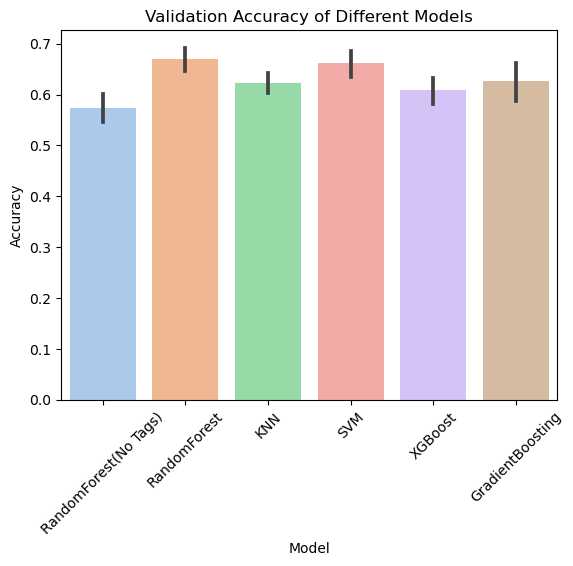

In [ ]:
sns.barplot(data=val_scores)
plt.title('Validation Accuracy of Different Models')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')

In [ ]:
val_performance = pd.DataFrame({
    'Model': ['RandomForest(No Tags)', 'RandomForest', 'KNN',
              'SVM', 'XGBoost', 'GradientBoosting'],
    'Accuracy': [rf_scores.mean(), rf_pca_scores.mean(), knn_scores.mean(),
                 svm_scores.mean(), xgb_scores.mean(), gb_scores.mean()]
})
val_performance.set_index('Model').T

Model,RandomForest(No Tags),RandomForest,KNN,SVM,XGBoost,GradientBoosting
Accuracy,0.573279,0.670288,0.621802,0.66218,0.60845,0.627243


We can see that among the traditional models, Random Forest and SVM with tag information seem to have the best average performance on the validation set, and other models with tag information can all achieve an average accuracy over 61%. The original Random Forest was poor in performance since it had no information about related tags of the prompts.

## Test Set Performance - Final Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
test_acc = []

In [ ]:
# random forest without tags categories
y_pred_rf = model_rf.predict(X_test)
test_acc.append((y_pred_rf == y_test).sum() / len(y_test))
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.59      0.27      0.37       136
           1       0.70      0.32      0.44       155
           2       0.60      0.81      0.69       214
           3       0.60      0.80      0.69       239

    accuracy                           0.61       744
   macro avg       0.62      0.55      0.55       744
weighted avg       0.62      0.61      0.58       744



In [ ]:
# random forest with PCA and tags categories
y_pred_rf_pca = model_rf_pca.predict(X_test_pca)
test_acc.append((y_pred_rf_pca == y_test).sum() / len(y_test))
print(classification_report(y_test, y_pred_rf_pca))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71       136
           1       0.90      0.23      0.36       155
           2       0.66      0.96      0.78       214
           3       0.78      0.82      0.80       239

    accuracy                           0.72       744
   macro avg       0.76      0.68      0.66       744
weighted avg       0.75      0.72      0.69       744



In [ ]:
# KNN with PCA and tags categories
y_pred_knn = model_knn.predict(X_test_pca)
test_acc.append((y_pred_knn == y_test).sum() / len(y_test))
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.73      0.70      0.71       136
           1       0.79      0.24      0.37       155
           2       0.66      0.99      0.79       214
           3       0.77      0.80      0.78       239

    accuracy                           0.72       744
   macro avg       0.74      0.68      0.66       744
weighted avg       0.74      0.72      0.69       744



In [ ]:
# SVM with PCA and tags categories
y_pred_svm = model_svm.predict(X_test_pca)
test_acc.append((y_pred_svm == y_test).sum() / len(y_test))
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       136
           1       0.76      0.30      0.43       155
           2       0.66      0.96      0.79       214
           3       0.81      0.78      0.79       239

    accuracy                           0.72       744
   macro avg       0.73      0.69      0.68       744
weighted avg       0.73      0.72      0.70       744



In [ ]:
# XGBoost
y_pred_xgb = model_xgb.predict(X_test_pca)
test_acc.append((y_pred_xgb == y_test).sum() / len(y_test))
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.53      0.62      0.58       136
           1       0.44      0.33      0.38       155
           2       0.58      0.64      0.61       214
           3       0.75      0.72      0.74       239

    accuracy                           0.60       744
   macro avg       0.58      0.58      0.57       744
weighted avg       0.60      0.60      0.60       744



In [ ]:
# Gradient Boosting
y_pred_gb = model_gb.predict(X_test_pca)
test_acc.append((y_pred_gb == y_test).sum() / len(y_test))
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.64      0.76      0.70       136
           1       0.69      0.34      0.45       155
           2       0.65      0.84      0.73       214
           3       0.81      0.77      0.79       239

    accuracy                           0.70       744
   macro avg       0.70      0.68      0.67       744
weighted avg       0.71      0.70      0.69       744



In [ ]:
# Bert
model = BertClassifier_l4()
model.load_state_dict(torch.load(
    'model_l4_e20_tag_related_title_no_pun_lrelu_lrelu_lrelu_softmax.pt',
      map_location='cuda' if torch.cuda.is_available() else 'cpu'))
bert_acc, y_pred_bert = evaluate(model, data_test)
test_acc.append(bert_acc)
print(classification_report(y_test, y_pred_bert))

  0%|          | 0/372 [00:00<?, ?it/s]

Test Accuracy:  0.800
              precision    recall  f1-score   support

           0       0.88      0.57      0.69       136
           1       0.91      0.62      0.74       155
           2       0.66      0.97      0.78       214
           3       0.91      0.89      0.90       239

    accuracy                           0.80       744
   macro avg       0.84      0.76      0.78       744
weighted avg       0.83      0.80      0.80       744



Text(0.5, 0, 'Model')

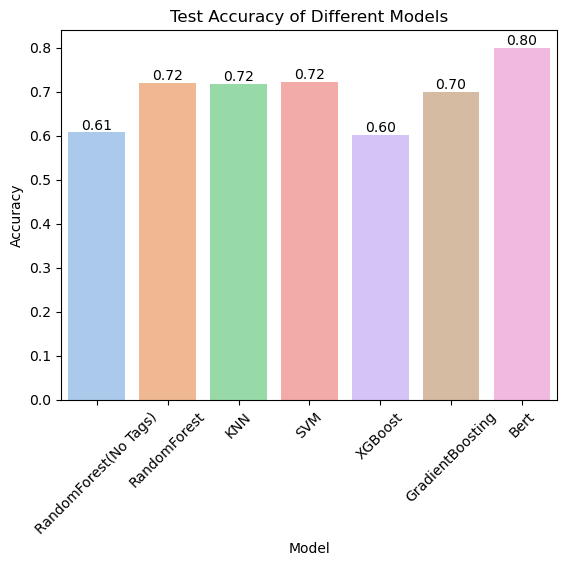

In [ ]:
models = ['RandomForest(No Tags)', 'RandomForest', 'KNN', 'SVM', 'XGBoost',
            'GradientBoosting', 'Bert']
ax = sns.barplot(x=models, y=test_acc)
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')
plt.title('Test Accuracy of Different Models')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')

In [ ]:
performance = pd.DataFrame({
    'Model': models,
    'Accuracy': test_acc
})
performance.set_index('Model').T

Model,RandomForest(No Tags),RandomForest,KNN,SVM,XGBoost,GradientBoosting,Bert
Accuracy,0.607527,0.719086,0.717742,0.721774,0.600806,0.700269,0.799731


 It turns out that on the test set, traditional classification models didn’t have better performance than our newly-introduced model BERT. While models like Random Forest, KNN and SVM could achieve accuracy of around 0.72, they performed badly at the recall rate. For most models, the recall rates were below 0.35 for category 1. However, BERT as a more comprehensive and complicated model, could achieve accuracy of 80% while remaining the recall rate to be greater than 0.5. This shows the strength and advantage of this state-of-art model in our classification task.